# Project Proposal Group 33


### Predicting a Tennis Player's Best Rank Based on Their Age, Seasons Played, Current Rank, and Prize Money

### Introduction


Tennis is a popular sport with a history of competitive tournaments and rankings. Tennis player rankings are essential to evaluate their performance but predicting a player's best rank can be difficult. This project aims to use K-nearest neighbor regression to predict a player's best rank based on age, seasons played, current rank, and prize money. The dataset will be analyzed using five-fold cross-validation, and visualization techniques such as scatter plots will provide insight into factors that influence ranking.

### Preliminary Data Analysis


In [92]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

The seed value is set to 4321 to enusre that every random process yields the same oucome when the code reruns.

In [48]:
set.seed(4321)

In [49]:
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
tennis_data <- read_csv(url)
head(tennis_data, n=10)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,28 (18-11-1991),United States,Right-handed,Wikipedia,307 (131),213 (31-10-2016),Sekou Bangoura,Two-handed,"$278,709",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,21 (12-05-1998),"Taiwan, Province of China",Right-handed,Wikipedia,232 (205),229 (04-11-2019),Tung Lin Wu,Two-handed,"$59,123",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,25 (29-07-1994),Uzbekistan,Right-handed,Wikipedia,417 (81),253 (17-07-2017),Sanjar Fayziev,Two-handed,"$122,734",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


For our project we chose the columns Age, Best Rank, Prize Money, Current Rank, and Seasons. These predictors were selected because they contain the most data compared to other columns which mostly contain N/As and all these variables have a direct or indirect impact on a player's performance.

We also isolated our desired variables, deleted empty observations, and removed unnecessary characters such as the unnecessary strings in the Prize Money varaible.

In [50]:
colnames(tennis_data) <- make.names(colnames(tennis_data))
tennis_data_separated <- tennis_data |> select(Age, Best.Rank, Prize.Money, Seasons, Current.Rank) |>
                separate(col = Age,
                        into = c("Age", "date"),
                        sep=" ",
                        convert=TRUE) |>
                separate(col = Best.Rank,
                        into = c("best_rank", "date_rank"),
                        sep=" ",
                        convert=TRUE) |>

                separate(col = Current.Rank,
                        into = c("current_rank", "date_cur_rank"),
                        sep=" ",
                        convert=TRUE) |>
    select(Age, best_rank, current_rank, Prize.Money, Seasons)

head(tennis_data_separated, n = 10)

Age,best_rank,current_rank,Prize.Money,Seasons
<int>,<int>,<int>,<chr>,<dbl>
26,363,378,NA,NA
18,316,326,"$59,040",NA
32,44,178,"US$3,261,567",14
21,130,236,"$374,093",2
27,17,183,"US$6,091,971",11
22,31,31,"$1,517,157",5
28,213,307,"$278,709",1
21,229,232,"$59,123",1
25,253,417,"$122,734",5


In [51]:
tennis_data_separated$Prize.Money <- gsub("US", " ", tennis_data_separated$Prize.Money)


tennis_data_separated$Prize.Money <- gsub("US", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("all-time leader in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("11th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("24th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("10th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("14th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("27th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("15th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("30th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("All-time leader in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("4th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("28th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("2nd", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("6th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("33rd", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("26th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("24th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("48th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("41st", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("\\$","", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub(" ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("   ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("  ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub(" all-time in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub(",", "", tennis_data_separated$Prize.Money)

tennis_data_renamed <- tennis_data_separated |>
    rename("Best_Rank" = "best_rank") |>
    rename("Current_Rank" = "current_rank")
head(tennis_data_renamed, n = 10)

Age,Best_Rank,Current_Rank,Prize.Money,Seasons
<int>,<int>,<int>,<chr>,<dbl>
26,363,378,NA,NA
18,316,326,59040,NA
32,44,178,3261567,14
21,130,236,374093,2
27,17,183,6091971,11
22,31,31,1517157,5
28,213,307,278709,1
21,229,232,59123,1
25,253,417,122734,5


We also converted the Prize Money column from character into double.

In [52]:
tennis_data_mutated <- tennis_data_renamed |>
    mutate(Prize_Money = as.numeric(Prize.Money)) |>
    na.omit() |>
    select(Age, Best_Rank, Current_Rank, Prize_Money, Seasons)

head(tennis_data_mutated, n = 10)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
32,44,178,3261567,14
21,130,236,374093,2
27,17,183,6091971,11
22,31,31,1517157,5
28,213,307,278709,1
21,229,232,59123,1
25,253,417,122734,5
20,104,104,74927,3
19,17,22,1893476,3


We split the data into 75% training and 25% testing datasets with starta set to  our target variable (Current_Rank). We will use the training set to train the model and the testing set to assess its accuracy. 

In [53]:
tennis_data_split <- initial_split(tennis_data_mutated, prop = .75, strata = Current_Rank)
tennis_data_train <- training(tennis_data_split)
tennis_data_test <- testing(tennis_data_split)
head(tennis_data_train, n = 10)
head(tennis_data_test, n = 10)

Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
22,31,31,1517157,5
19,17,22,1893476,3
23,4,4,10507693,5
20,47,54,1285541,3
22,25,34,2722314,6
32,11,45,11912152,15
32,9,12,13470614,16
29,23,27,4850190,11
29,32,32,2301746,13


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
21,130,236,374093,2
30,98,105,898701,7
20,187,331,127760,2
34,48,408,3186839,14
27,11,14,7217264,8
27,26,41,3062847,11
28,10,30,8892564,9
22,298,344,71874,6
34,62,461,1453933,10


In [54]:
tennis_data_train_mean <- tennis_data_train |> map_df(mean)
tennis_data_train_median <- tennis_data_train |> map_df(median)

print("Training Tennis Data Mean")
tennis_data_train_mean
print("Training Tennis Data Median")
tennis_data_train_median

[1] "Training Tennis Data Mean"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26.70221,128.8971,206.625,4493456,6.422794


[1] "Training Tennis Data Median"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26.5,99,193.5,648769.5,5


The tables above show that the data needs to be standardized since our predictors have very different ranges and we do not want the predictors with larger sclaes (such as Prize_Money) to have a greater effect on our model than the ones with smaller scales (such as Seasons). We can also observe that Prize_Money has a much larger mean value compared to is median value which could point to potential outliers that are boosting the avarage and skewing the distribution which again suggests we should standardize our data.

// Need to add visuals 

### Methods

#### Recipe:

Since we need to standardize the data before any further analysis, we will begin by making a recipe that contains all predictor variables (tennis_data_recipe) as well as four other recipes for each of the predictors individually. 

In [80]:
tennis_data_recipe <- recipe(Best_Rank ~ Age + Current_Rank + Prize_Money + Seasons, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_age <- recipe(Best_Rank ~ Age, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_cr <- recipe(Best_Rank ~ Current_Rank, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_pm <- recipe(Best_Rank ~ Prize_Money + Seasons, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

tennis_data_recipe_seasons <- recipe(Best_Rank ~ Seasons, data = tennis_data_train)|>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

#### model specification:

Next me create our regression model, setting neighbors to tune() to find the best value of k.

In [56]:
tennis_data_specs <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")
tennis_data_specs

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### Workflow:

Now we make the workflow for the model  using the tennis_data_recipe_age and tennis_data_specs

In [57]:
tennis_data_workflow_age <- workflow() |>
    add_recipe(tennis_data_recipe_age) |>
    add_model(tennis_data_specs)

tennis_data_workflow_age

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [58]:
tennis_data_vfold <- vfold_cv(tennis_data_train, v = 5, strata = Best_Rank)

gridvals <- tibble <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

age_result <- tennis_data_workflow_age |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(age_result, n= 10)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,141.5229,5,2.916589,Preprocessor1_Model01
3,rmse,standard,127.8889,5,5.877883,Preprocessor1_Model02
5,rmse,standard,124.6313,5,4.344264,Preprocessor1_Model03
7,rmse,standard,115.9401,5,3.671743,Preprocessor1_Model04
9,rmse,standard,109.2535,5,4.056690,Preprocessor1_Model05
11,rmse,standard,107.5377,5,3.272478,Preprocessor1_Model06
13,rmse,standard,103.3944,5,2.908761,Preprocessor1_Model07
15,rmse,standard,102.5761,5,3.006217,Preprocessor1_Model08
17,rmse,standard,101.0953,5,3.091057,Preprocessor1_Model09


In [59]:
kmin_age_df <- age_result |>
    filter(mean == min(mean))

kmin_age <- kmin_age_df |>
    pull(neighbors)

kmin_age_df


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
35,rmse,standard,98.9932,5,3.443518,Preprocessor1_Model18


Now we use k = 35 for our knn regression model

In [94]:
tennis_data_specs_age <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_age) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_age <- workflow() |>
    add_recipe(tennis_data_recipe_age) |>
    add_model(tennis_data_specs_age) |>
    fit(data = tennis_data_train)

age_pred <- tennis_data_fit_age |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


age_summary <- age_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

age_rmspe <- age_summary |>
    pull(.estimate) |>
    round(digits = 0)

age_summary
age_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,85.21543


[1] 85

The RMSPE of the model with the age predictor is 85.

Here is plot for this model.

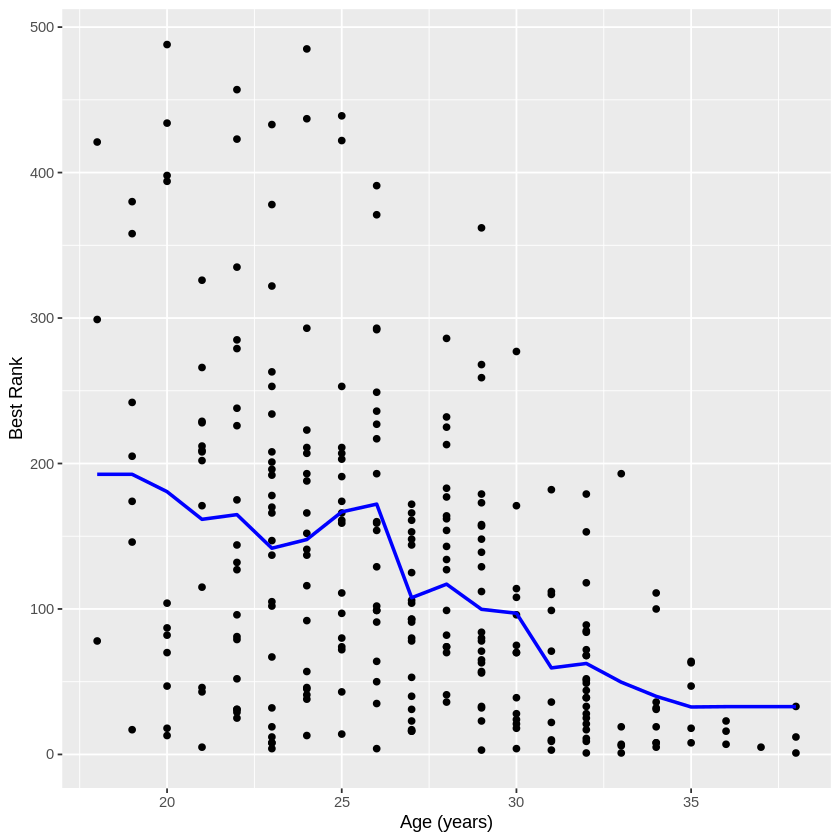

In [72]:
###### WHYYYYYY???? ##################

age_train_info <- tennis_data_fit_age |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)

age_plot <- tennis_data_train |>
    ggplot(aes(x = Age, y = Best_Rank)) +
    geom_point() +
    geom_line(data = age_train_info, mapping = aes(x = Age, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Age (years)", y = "Best Rank")
    
age_plot



Now we will do the same analysis for the other predictors.

Here is the model for Current Rank

In [64]:

tennis_data_workflow_cr <- workflow() |>
    add_recipe(tennis_data_recipe_cr) |>
    add_model(tennis_data_specs)


cr_result <- tennis_data_workflow_cr |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(cr_result, n= 10)

kmin_cr_df <- cr_result |>
    filter(mean == min(mean))

kmin_cr <- kmin_cr_df |>
    pull(neighbors)

kmin_cr_df

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,109.23120,5,4.090562,Preprocessor1_Model01
3,rmse,standard,85.30967,5,3.077771,Preprocessor1_Model02
5,rmse,standard,81.27808,5,2.961570,Preprocessor1_Model03
7,rmse,standard,77.17757,5,1.729806,Preprocessor1_Model04
9,rmse,standard,76.70516,5,1.630680,Preprocessor1_Model05
11,rmse,standard,75.74243,5,1.762825,Preprocessor1_Model06
13,rmse,standard,76.56816,5,1.776008,Preprocessor1_Model07
15,rmse,standard,77.27376,5,1.655659,Preprocessor1_Model08
17,rmse,standard,76.26561,5,1.962916,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,rmse,standard,74.67103,5,1.655292,Preprocessor1_Model15


In [95]:
tennis_data_specs_cr <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_cr) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_cr <- workflow() |>
    add_recipe(tennis_data_recipe_cr) |>
    add_model(tennis_data_specs_cr) |>
    fit(data = tennis_data_train)

cr_pred <- tennis_data_fit_cr |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


cr_summary <- cr_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

cr_rmspe <- cr_summary |>
    pull(.estimate) |>
    round(digits = 0)


cr_summary
cr_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,74.00491


[1] 74

The RMSPE of the model with the Current Rank predictor is 74.

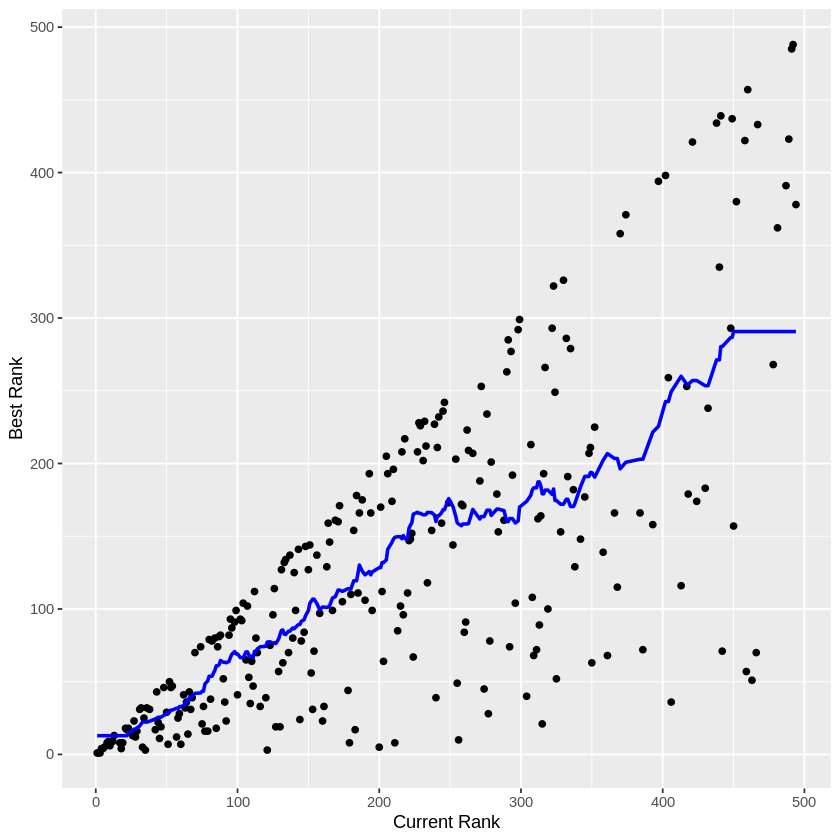

In [71]:
###### WHYYYYYY???? ##################

cr_train_info <- tennis_data_fit_cr |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)
##################

cr_plot <- tennis_data_train |>
    ggplot(aes(x = Current_Rank, y = Best_Rank)) +
    geom_point() +
    geom_line(data = cr_train_info, mapping = aes(x = Current_Rank, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Current Rank", y = "Best Rank")
    
cr_plot



Prize Money:

In [74]:

tennis_data_workflow_pm <- workflow() |>
    add_recipe(tennis_data_recipe_pm) |>
    add_model(tennis_data_specs)


pm_result <- tennis_data_workflow_pm |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(pm_result, n= 10)

kmin_pm_df <- pm_result |>
    filter(mean == min(mean))

kmin_pm <- kmin_pm_df |>
    pull(neighbors)

kmin_pm_df


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,59.93681,5,2.332886,Preprocessor1_Model01
3,rmse,standard,53.17634,5,2.530858,Preprocessor1_Model02
5,rmse,standard,52.24231,5,1.943435,Preprocessor1_Model03
7,rmse,standard,54.09623,5,2.033985,Preprocessor1_Model04
9,rmse,standard,55.73714,5,2.487152,Preprocessor1_Model05
11,rmse,standard,57.74722,5,2.809199,Preprocessor1_Model06
13,rmse,standard,60.23925,5,2.997032,Preprocessor1_Model07
15,rmse,standard,62.48209,5,2.456793,Preprocessor1_Model08
17,rmse,standard,63.87564,5,2.152834,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,rmse,standard,52.24231,5,1.943435,Preprocessor1_Model03


In [96]:
tennis_data_specs_pm <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_pm) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_pm <- workflow() |>
    add_recipe(tennis_data_recipe_pm) |>
    add_model(tennis_data_specs_pm) |>
    fit(data = tennis_data_train)

pm_pred <- tennis_data_fit_pm |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


pm_summary <- pm_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")


pm_rmspe <- pm_summary |>
    pull(.estimate) |>
    round(digits = 0)


pm_summary
pm_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,53.37726


[1] 53

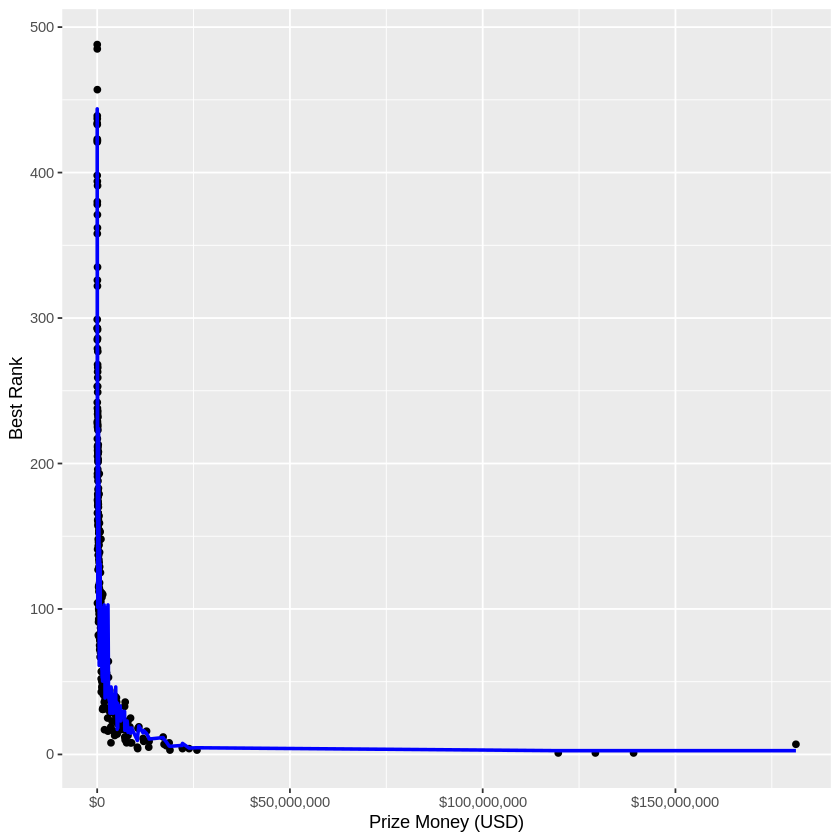

In [78]:
###### WHYYYYYY???? ##################

pm_train_info <- tennis_data_fit_pm |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)
##################

pm_plot <- tennis_data_train |>
    ggplot(aes(x = Prize_Money, y = Best_Rank)) +
    geom_point() +
    geom_line(data = pm_train_info, mapping = aes(x = Prize_Money, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Prize Money (USD)", y = "Best Rank") +
    scale_x_continuous(labels = dollar_format())
    
pm_plot


Seasons:

In [81]:

tennis_data_workflow_seasons <- workflow() |>
    add_recipe(tennis_data_recipe_seasons) |>
    add_model(tennis_data_specs)


seasons_result <- tennis_data_workflow_seasons |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(seasons_result, n= 10)

kmin_seasons_df <- seasons_result |>
    filter(mean == min(mean))

kmin_seasons <- kmin_seasons_df |>
    pull(neighbors)

kmin_seasons_df

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,104.99873,5,3.269358,Preprocessor1_Model01
3,rmse,standard,102.66148,5,1.787143,Preprocessor1_Model02
5,rmse,standard,98.67445,5,1.839567,Preprocessor1_Model03
7,rmse,standard,93.71873,5,2.968352,Preprocessor1_Model04
9,rmse,standard,90.33033,5,2.723737,Preprocessor1_Model05
11,rmse,standard,87.53619,5,2.863786,Preprocessor1_Model06
13,rmse,standard,85.63570,5,2.704412,Preprocessor1_Model07
15,rmse,standard,82.98863,5,2.619282,Preprocessor1_Model08
17,rmse,standard,79.42768,5,2.411004,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
35,rmse,standard,75.95599,5,2.648092,Preprocessor1_Model18


In [97]:
tennis_data_specs_seasons <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin_seasons) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit_seasons <- workflow() |>
    add_recipe(tennis_data_recipe_seasons) |>
    add_model(tennis_data_specs_seasons) |>
    fit(data = tennis_data_train)

seasons_pred <- tennis_data_fit_seasons |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


seasons_summary <- seasons_pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

seasons_rmspe <- seasons_summary |>
        pull(.estimate) |>
    round(digits = 0)

seasons_summary
seasons_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,70.42583


[1] 70

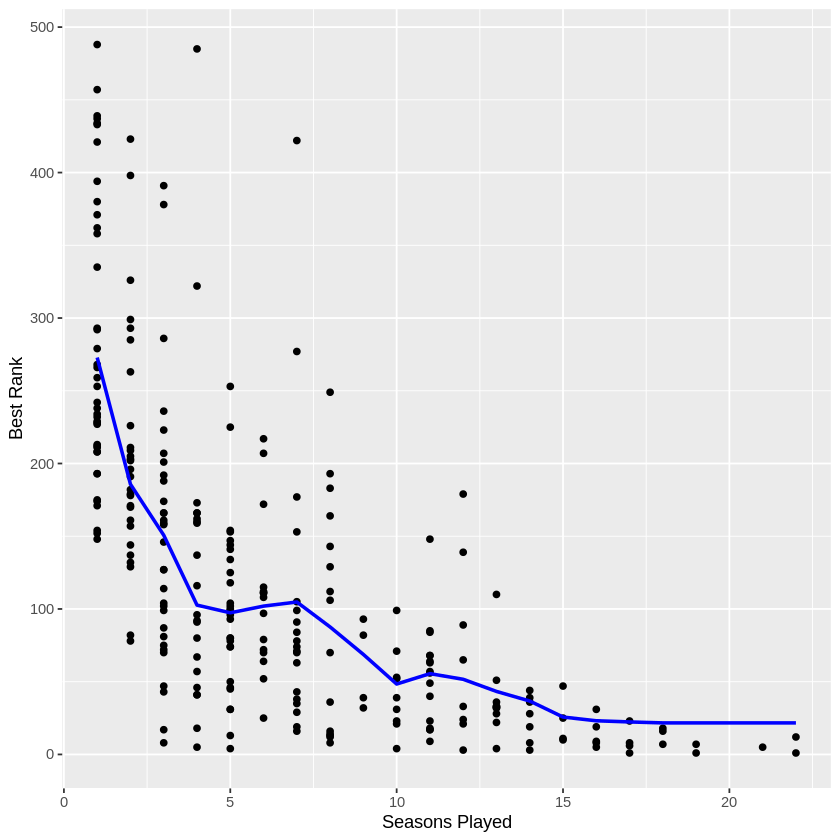

In [85]:
###### WHYYYYYY???? ##################

seasons_train_info <- tennis_data_fit_seasons |>
    predict(tennis_data_train) |>
    bind_cols(tennis_data_train)
##################

seasons_plot <- tennis_data_train |>
    ggplot(aes(x = Seasons, y = Best_Rank)) +
    geom_point() +
    geom_line(data = seasons_train_info, mapping = aes(x = Seasons, y = .pred),
                color = "blue",
                size = 1) +
    labs(x = "Seasons Played", y = "Best Rank")
    
seasons_plot

With all:

In [86]:
tennis_data_workflow <- workflow() |>
    add_recipe(tennis_data_recipe) |>
    add_model(tennis_data_specs)


result <- tennis_data_workflow |>
    tune_grid(resample = tennis_data_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

head(result, n= 10)

kmin_df <- result |>
    filter(mean == min(mean))

kmin <- kmin_df |>
    pull(neighbors)

kmin_df

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,60.46635,5,4.216584,Preprocessor1_Model01
3,rmse,standard,52.46674,5,3.546586,Preprocessor1_Model02
5,rmse,standard,49.48657,5,3.059217,Preprocessor1_Model03
7,rmse,standard,48.83296,5,1.681082,Preprocessor1_Model04
9,rmse,standard,48.56007,5,1.219980,Preprocessor1_Model05
11,rmse,standard,48.68308,5,1.368194,Preprocessor1_Model06
13,rmse,standard,48.22293,5,1.889419,Preprocessor1_Model07
15,rmse,standard,48.68259,5,1.835935,Preprocessor1_Model08
17,rmse,standard,49.58250,5,1.882717,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,rmse,standard,48.22293,5,1.889419,Preprocessor1_Model07


In [98]:
tennis_data_specs_min <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")


tennis_data_fit <- workflow() |>
    add_recipe(tennis_data_recipe) |>
    add_model(tennis_data_specs_min) |>
    fit(data = tennis_data_train)

pred <- tennis_data_fit |>
    predict(tennis_data_test) |>
    bind_cols(tennis_data_test)


summary <- pred |>
    metrics(truth = Best_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

all_rmspe <- summary |>
    pull(.estimate) |>
    round(digits = 0)

summary
all_rmspe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,46.70899


[1] 47

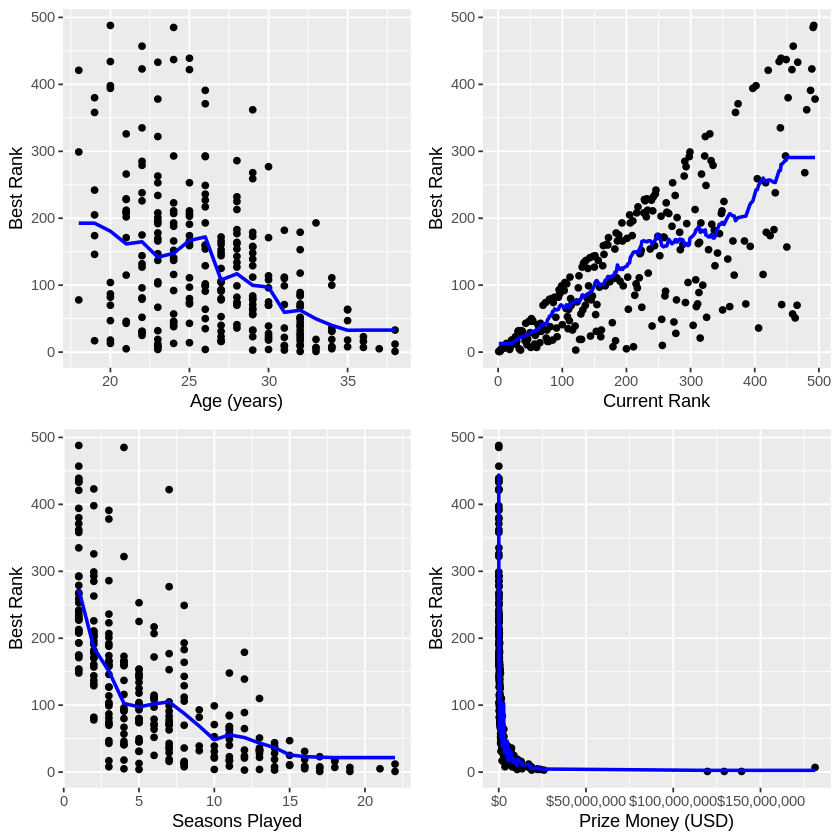

In [93]:
plot_grid(age_plot, cr_plot, seasons_plot, pm_plot)

In [100]:
RMSPE <- c (age_rmspe, cr_rmspe, pm_rmspe, seasons_rmspe, all_rmspe)

model <- c ("Age", "Current Rank", "Prize Money", "Seasons Played", "Final Model")

comparison_df <- data.frame(model, RMSPE) |>
    arrange(RMSPE)

comparison_df

model,RMSPE
<chr>,<dbl>
Final Model,47
Prize Money,53
Seasons Played,70
Current Rank,74
Age,85


### Results

### Discussion

### References